In [1]:
# BITÁCORA DE CAMBIOS
# fe_2:     Lags simples
# fe_3:     Agregado multiple FE para fechas
# fe_4:     Arreglado los lags
# fe_5:     Agregado de los meses como seno y coseno
# fe_6:     Agrego features de Prophet
# fe_7:     Nueva tabla productos
# fe_8:     Modifico max_bins xgboost --> Kaggle: 0.255 
# fe_9:     Modifico sku_size como categorica
# fe_10:    Estandarizar todos los atributos y agrego el nuevo dataset de productos -> Empeora con xgboost depth 30, dejar en 15
# fe_11:    Voy a agregar un canario *3
# fe_12:    Voy a agregar un canario *10
# fe_13:    Agrego stocks
# fe_14:    Agregar product_id como variable del modelo
# fe_15:    Agrego clusters como categóricas
# fe_16:    Sku como numéricas y agrego 201910 como training y test
# fe_17:    Entrenamiento por clusters
# fe_18:    Data engineering lags 36
# fe_19:    Agrego algunas variables exogenas
# fe_19b:   Agrego algunas variables exogenas arreglo NAs
# fe_20:    Vector de pesos 
# fe_20b:   Vector de pesos + arreglo Prophet
# fe_20c:   Vector de pesos (arreglado) + arreglo Prophet
# fe_24:    Hyperparameters + 12 lags
# fe_25:    Hyperparameters + 12 lags sin exogenas

### Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import os
from datetime import datetime

from custom_fxs import crear_directorios_xp, cargar_datasets, feature_engineering, scaler_std, pipeline_fit_with_eval_set_weights, invert_transformation, plot_predictions, plot_top_features_importance, asignar_familia

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

import optuna

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

c:\Users\ferna\.conda\envs\labo3_311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Cloud / Local

In [9]:
CLOUD = False

if CLOUD == True:
    ROOT = "/home/fernando_damian_coz/buckets/b1/datasets/"
else:
    ROOT = "C:/Austral/labo3-fdc/Datasets/"

### Configuración experimento

In [7]:
EXPERIMENTO = "xgb_fe35"
MODELOS, PLOTS, PREDS, NB = crear_directorios_xp()

### Carga de datos

### Base

In [3]:
df_sells_filtrado, df_prods_filtrado, df_stocks_filtrado = cargar_datasets(CLOUD, filtrado=True)

In [4]:
df_prods_filtrado.sort_values(by=['descripcion', 'sku_size'], ascending=[True, True]).reset_index(drop=True)

,cat1,cat2,cat3,brand,sku_size,product_id,descripcion
0,PC,PIEL2,Toallitas Bebe,NIVEA,50,20642,AA
1,PC,DENTAL,CREMA,COLGATE,90,20883,AA
2,HC,VAJILLA,Cristalino,Importado,500,20524,Abrillantador
3,HC,VAJILLA,Cristalino,Importado,1000,20311,Abrillantador
4,PC,CABELLO,Acond Bebe,NIVEA,200,20783,Acondicinador Bebe
...,...,...,...,...,...,...,...
775,PC,CABELLO,ACONDICIONADOR,SHAMPOO3,650,20383,rulos vitales
776,PC,DEOS,Aero,SHAMPOO2,150,20945,sport
777,PC,DEOS,Aero,SHAMPOO2,150,20951,sport extremo
778,PC,PIEL1,CREMA,LANCOME,350,20538,trigo


### Familia de productos

In [6]:
df_prods_familia = pd.DataFrame(df_prods_filtrado)

# Crear nuevas columnas para los resultados
df_prods_familia['hermano_mayor'] = None
df_prods_familia['hermano_menor'] = None
df_prods_familia['mellizo'] = None

df_prods_familia = df_prods_familia.groupby(['cat1', 'cat2', 'cat3', 'brand', 'descripcion']).apply(asignar_familia).reset_index(drop=True)
df_prods_familia

C:\Users\ferna\AppData\Local\Temp\ipykernel_17136\620100813.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_prods_familia = df_prods_familia.groupby(['cat1', 'cat2', 'cat3', 'brand', 'descripcion']).apply(asignar_familia).reset_index(drop=True)


,cat1,cat2,cat3,brand,sku_size,product_id,descripcion,hermano_mayor,hermano_menor,mellizo
0,FOODS,ADEREZOS,Aji Picante,NATURA,240,20609,Salsa Aji Picante,[],[],None
1,FOODS,ADEREZOS,Barbacoa,NATURA,250,20266,Salsa Barbacoa,"[20325, 20503]",[],None
2,FOODS,ADEREZOS,Barbacoa,NATURA,400,20325,Salsa Barbacoa,[20503],[20266],None
3,FOODS,ADEREZOS,Barbacoa,NATURA,500,20503,Salsa Barbacoa,[],"[20266, 20325]",None
4,FOODS,ADEREZOS,Ketchup,MAJESTA,240,20299,Ketchup,[],[],None
...,...,...,...,...,...,...,...,...,...,...
775,REF,TE,Especial,TWININGS,20,21170,EG,[],[],None
776,REF,TE,Hierbas,TWININGS,20,21202,Manzanilla,[],[],None
777,REF,TE,Hierbas,TWININGS,20,21218,Menta,[],[],None
778,REF,TE,Verde,TWININGS,20,21192,Verde,[],[],None


### Pruebo agregar columnas de familia

In [7]:
df_sells_agg = df_sells_filtrado.groupby(['product_id', 'periodo','plan_precios_cuidados']).agg({'tn': 'sum','cust_request_qty': 'sum','cust_request_tn': 'sum'}).reset_index()

df2 = df_sells_agg.merge(df_prods_familia[['product_id', 'hermano_mayor', 'hermano_menor', 'mellizo']], on='product_id', how='left')

In [8]:
def get_tn(df, product_list, period):
    return df[(df['product_id'].isin(product_list)) & (df['periodo'] == period)]['tn'].tolist()

for i in range(len(df2)):
    period = df2.loc[i, 'periodo']
    mayor_list = df2.loc[i, 'hermano_mayor']
    menor_list = df2.loc[i, 'hermano_menor']
    twin_id = df2.loc[i, 'mellizo']
    
    mayor_tn = get_tn(df2, mayor_list, period) if mayor_list else []
    menor_tn = get_tn(df2, menor_list, period) if menor_list else []  
    twin_tn = get_tn(df2, twin_id, period) if isinstance(twin_id, list) else []
    
    for j, tn in enumerate(mayor_tn):
        df2.at[i, f'hermano_mayor_{j+1}'] = tn
    for j, tn in enumerate(menor_tn):
        df2.at[i, f'hermano_menor_{j+1}'] = tn
    df2.at[i, 'mellizo_tn'] = twin_tn[0] if twin_tn else None

df2 = df2.drop(columns=['hermano_mayor', 'hermano_menor', 'mellizo'])

df2

,product_id,periodo,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,hermano_menor_1,mellizo_tn,hermano_menor_2,hermano_menor_3,hermano_mayor_1,hermano_mayor_2,hermano_mayor_3,hermano_mayor_4,hermano_menor_4
0,20001,201701,0,934.77222,479,937.72717,114.16856,116.86614,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20001,201702,0,798.01620,432,833.72187,157.94664,68.92650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20001,201703,0,1303.35771,509,1330.74697,157.61530,159.98159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20001,201704,0,1069.96130,279,1132.94430,190.20933,77.07501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20001,201705,0,1502.20132,701,1550.68936,184.94423,125.65265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22344,21276,201908,0,0.01265,7,0.01265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22345,21276,201909,0,0.01856,10,0.01856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22346,21276,201910,0,0.02079,13,0.02079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22347,21276,201911,0,0.03341,12,0.03341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_prods_familia.query("product_id == 20102")

,cat1,cat2,cat3,brand,sku_size,product_id,descripcion,hermano_mayor,hermano_menor,mellizo
249,HC,ROPA LAVADO,Liquido,ARIEL,3000,20102,genoma,[],"[20261, 20045, 20150]",[20001]


In [10]:
df2.query("product_id == 20102")

,product_id,periodo,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,hermano_menor_1,mellizo_tn,hermano_menor_2,hermano_menor_3,hermano_mayor_1,hermano_mayor_2,hermano_mayor_3,hermano_mayor_4,hermano_menor_4
3204,20102,201701,0,116.86614,231,118.09737,114.16856,934.77222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3205,20102,201702,0,68.92650,226,71.83668,157.94664,798.01620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3206,20102,201703,0,159.98159,336,161.14566,157.61530,1303.35771,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3207,20102,201704,0,77.07501,226,77.07501,190.20933,1069.96130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3208,20102,201705,0,125.65265,302,125.65265,184.94423,1502.20132,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3209,20102,201706,0,101.58766,337,101.58767,190.27205,1520.06539,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3210,20102,201707,0,86.84650,191,86.84650,152.54712,1030.67391,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3211,20102,201708,0,76.86229,282,76.86231,161.09854,1267.39462,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3212,20102,201709,0,70.72858,271,70.72858,211.82531,1316.94604,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3213,20102,201710,0,123.78344,280,123.78344,219.67831,1439.75563,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df2.query("product_id == 20001")

,product_id,periodo,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,hermano_menor_1,mellizo_tn,hermano_menor_2,hermano_menor_3,hermano_mayor_1,hermano_mayor_2,hermano_mayor_3,hermano_mayor_4,hermano_menor_4
0,20001,201701,0,934.77222,479,937.72717,114.16856,116.86614,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20001,201702,0,798.01620,432,833.72187,157.94664,68.92650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20001,201703,0,1303.35771,509,1330.74697,157.61530,159.98159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20001,201704,0,1069.96130,279,1132.94430,190.20933,77.07501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20001,201705,0,1502.20132,701,1550.68936,184.94423,125.65265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20001,201706,0,1520.06539,570,1575.82891,190.27205,101.58766,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,20001,201707,0,1030.67391,381,1086.47101,152.54712,86.84650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,20001,201708,0,1267.39462,643,1289.66869,161.09854,76.86229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,20001,201709,0,1316.94604,381,1356.96103,211.82531,70.72858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,20001,201710,0,1439.75563,273,1441.60247,219.67831,123.78344,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Prophet

In [13]:
prophet_data = ROOT + "prophet_fe_data.csv"

df_prophet = pd.read_csv(prophet_data, decimal='.', delimiter=',', encoding='utf-8')

columnas= ['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 
                          'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 
                          'yearly', 'yearly_lower', 'yearly_upper']

#for columna in columnas:
#    df_prophet[columna] = df_prophet[columna].apply(lambda x: max(x, 0))
    
df_prophet['periodo'] = pd.to_datetime(df_prophet['ds'], format='%Y-%m-%d')
df_prophet['periodo'] = df_prophet['periodo'].dt.strftime('%Y%m').astype(int)

columnas_seleccionadas= ['periodo', 'product_id', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 
                          'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 
                          'yearly', 'yearly_lower', 'yearly_upper']

df_prophet = df_prophet[columnas_seleccionadas]

### Agrupación y joins

In [14]:
# Agrupo por PRODUCT_ID + PERIODO
df_sells_agg = df_sells_filtrado.groupby(['product_id', 'periodo','plan_precios_cuidados']).agg({'tn': 'sum','cust_request_qty': 'sum','cust_request_tn': 'sum'}).reset_index()

# JOIN tb_productos
df_sells_agg  = df_sells_agg.merge(df_prods_filtrado, on='product_id', how='left')

# JOIN stocks
df_sells_agg  = df_sells_agg.merge(df_stocks_filtrado, on=['product_id', 'periodo'], how='left')

# JOIN data Pophet
df_sells_agg  = df_sells_agg.merge(df_prophet, on=['product_id', 'periodo'], how='left')

# JOIN con Clusters
#cl5 = pd.read_csv("../Datasets/5_clusters.csv", index_col=False)
#cl10 = pd.read_csv("../Datasets/10_clusters.csv", index_col=False)
#cl20 = pd.read_csv("../Datasets/20_clusters.csv", index_col=False)
cl50 = pd.read_csv(ROOT + "50_clusters.csv", index_col=False)
#cl100 = pd.read_csv("../Datasets/100_clusters.csv", index_col=False)

#df_sells_agg = df_sells_agg.merge(cl5.rename(columns={'cluster': 'cluster_5'}), on='product_id', how='left')
#df_sells_agg = df_sells_agg.merge(cl10.rename(columns={'cluster': 'cluster_10'}), on='product_id', how='left')
#df_sells_agg = df_sells_agg.merge(cl20.rename(columns={'cluster': 'cluster_20'}), on='product_id', how='left')
df_sells_agg = df_sells_agg.merge(cl50.rename(columns={'cluster': 'cluster_50'}), on='product_id', how='left')
#df_sells_agg = df_sells_agg.merge(cl100.rename(columns={'cluster': 'cluster_100'}), on='product_id', how='left')

df_sells_agg.head()

,product_id,periodo,plan_precios_cuidados,tn,cust_request_qty,cust_request_tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,cluster_50
0,20001,201701,0,934.77222,479,937.72717,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,-240.118444,-240.118444,-240.118444,-240.118444,-240.118444,-240.118444,16
1,20001,201702,0,798.01620,432,833.72187,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1262.235256,552.200472,1185.622572,1262.235256,1262.235256,-391.702066,-391.702066,-391.702066,-391.702066,-391.702066,-391.702066,16
2,20001,201703,0,1303.35771,509,1330.74697,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1271.645129,1169.577591,1836.598993,1271.645129,1271.645129,241.601638,241.601638,241.601638,241.601638,241.601638,241.601638,16
3,20001,201704,0,1069.96130,279,1132.94430,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1280.751458,743.639264,1375.402442,1280.751458,1280.751458,-215.814799,-215.814799,-215.814799,-215.814799,-215.814799,-215.814799,16
4,20001,201705,0,1502.20132,701,1550.68936,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1290.161331,1094.231747,1724.686243,1290.161331,1290.161331,118.402960,118.402960,118.402960,118.402960,118.402960,118.402960,16


### Variables exogenas

In [14]:
#df_exogenas = pd.read_excel("../Datasets/exogenas.xlsx", index_col=False)
#df_sells_agg  = df_sells_agg.merge(df_exogenas, on='periodo', how='left')

### Alpiste para canario

In [15]:
#df_sells_agg = producto_canario(df_sells_agg)

### Estandarizo cada serie

In [11]:
columnas_escalar = [
    'cust_request_tn', 'trend', 'yhat_lower', 'yhat_upper', 
    'trend_lower', 'trend_upper', 'additive_terms', 
    'additive_terms_lower', 'additive_terms_upper', 
    'yearly', 'yearly_lower', 'yearly_upper', 'stock_final'
]

In [12]:
df_transformed, scaler_dict = scaler_std(df_sells_agg, columnas_escalar)

c:\Users\ferna\.conda\envs\labo3_311\Lib\site-packages\sklearn\utils\extmath.py:1140: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\ferna\.conda\envs\labo3_311\Lib\site-packages\sklearn\utils\extmath.py:1145: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\ferna\.conda\envs\labo3_311\Lib\site-packages\sklearn\utils\extmath.py:1165: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


### Feature Engineering

In [15]:
df_fe = feature_engineering(df_sells_agg, 12)

### Imputo los nulos

In [16]:
#df_merged_agg_final = df_fe.fillna(0)
df_merged_agg_final = df_fe

In [17]:
column = df_merged_agg_final.pop('tn')
df_merged_agg_final['tn'] = column
df_merged_agg_final

,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,cluster_50,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,delta_lag_1,delta_lag_2,delta_lag_3,delta_lag_4,delta_lag_5,delta_lag_6,delta_lag_7,delta_lag_8,delta_lag_9,delta_lag_10,delta_lag_11,delta_lag_12,moving_avg_1,moving_avg_2,moving_avg_3,moving_avg_4,moving_avg_5,moving_avg_6,moving_avg_7,moving_avg_8,moving_avg_9,moving_avg_10,moving_avg_11,moving_avg_12,ratio_3,ratio_6,max_2_months,min_2_months,max_3_months,min_3_months,max_4_months,min_4_months,max_5_months,min_5_months,max_6_months,min_6_months,max_7_months,min_7_months,max_8_months,min_8_months,max_9_months,min_9_months,max_10_months,min_10_months,max_11_months,min_11_months,max_12_months,min_12_months,Year,Month,Q,Days_Month,month_sin,month_cos,tn
0,20001,2017-01-01,0,479,937.72717,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1253.736016,658.150779,1335.665069,1253.736016,1253.736016,-240.118444,-240.118444,-240.118444,-240.118444,-240.118444,-240.118444,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017,1,3,31,5.000000e-01,8.660254e-01,934.77222
1,20001,2017-02-01,0,432,833.72187,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1262.235256,552.200472,1185.622572,1262.235256,1262.235256,-391.702066,-391.702066,-391.702066,-391.702066,-391.702066,-391.702066,16,934.77222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,934.77222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017,2,3,28,8.660254e-01,5.000000e-01,798.01620
2,20001,2017-03-01,0,509,1330.74697,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1271.645129,1169.577591,1836.598993,1271.645129,1271.645129,241.601638,241.601638,241.601638,241.601638,241.601638,241.601638,16,798.01620,934.77222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-136.75602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,798.01620,866.394210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017,3,3,31,1.000000e+00,6.123234e-17,1303.35771
3,20001,2017-04-01,0,279,1132.94430,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1280.751458,743.639264,1375.402442,1280.751458,1280.751458,-215.814799,-215.814799,-215.814799,-215.814799,-215.814799,-215.814799,16,1303.35771,798.01620,934.77222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,505.34151,-136.75602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1303.35771,1050.686955,1012.048710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.057223,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017,4,4,30,8.660254e-01,-5.000000e-01,1069.96130
4,20001,2017-05-01,0,701,1550.68936,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,NaN,1290.161331,1094.231747,1724.686243,1290.161331,1290.161331,118.402960,118.402960,118.402960,118.402960,118.402960,118.402960,16,1069.96130,1303.35771,798.01620,934.77222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-233.39641,505.34151,-136.75602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1069.96130,1186.659505,1057.111737,1026.526858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.421043,NaN,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017,5,4,31,5.000000e-01,-8.660254e-01,1502.20132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22344,21276,2019-08-01,0,7,0.01265,PC,PIEL1,Cara,NIVEA,140,reconstruccion,1.08488,0.074864,0.012648,0.012648,0.074864,0.074864,-0.062216,-0.

### Agrego el target

In [20]:
df_merged_agg_final['target_2'] = df_merged_agg_final.groupby('product_id')['tn'].shift(-2)

### Ratio como target

In [23]:
df_merged_agg_final['target'] = df_merged_agg_final['target_2'] / df_merged_agg_final['tn']

In [25]:
df_merged_agg_final.drop(columns=['target_2'], inplace=True)

### Pesos custom

In [30]:
df_2019 = df_merged_agg_final[(df_merged_agg_final['periodo'] >= '2019-01-01') & (df_merged_agg_final['periodo'] <= '2019-12-31')]

weights = df_2019.groupby('product_id')['tn'].mean().reset_index()

weights.rename(columns={'tn': 'weights'}, inplace=True)

df_merged_agg_final = df_merged_agg_final.merge(weights, on='product_id', how='left')

### Split Temporal

In [32]:
numeric_columns = df_merged_agg_final.select_dtypes(include=['number']).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in ['target']]

categorical_columns = df_merged_agg_final.select_dtypes(include=['object']).columns.tolist()
categorical_columns = [col for col in categorical_columns if col not in ['periodo']]

categorical_columns.append('plan_precios_cuidados')

numeric_columns.remove('plan_precios_cuidados')
numeric_columns.remove('weights')

In [33]:
for col in categorical_columns:
    df_merged_agg_final[col] = df_merged_agg_final[col].astype("category")

In [34]:
df_merged_agg_final['periodo'] = pd.to_datetime(df_merged_agg_final['periodo'], format='%Y%m')

train = df_merged_agg_final[df_merged_agg_final['periodo'] < pd.to_datetime('201910', format='%Y%m')]
validation = df_merged_agg_final[df_merged_agg_final['periodo'] == pd.to_datetime('201910', format='%Y%m')]

test = df_merged_agg_final[df_merged_agg_final['periodo'] > pd.to_datetime('201910', format='%Y%m')]

In [35]:
X_train = train.drop(columns=['target', 'weights'])
y_train = train['target']
w_train = train['weights']

X_validation = validation.drop(columns=['target', 'weights'])
y_validation = validation['target']
w_validation = validation['weights']

test.drop(columns=['target', 'weights'], inplace=True)

C:\Users\ferna\AppData\Local\Temp\ipykernel_7496\1635910362.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns=['target', 'weights'], inplace=True)


### Train XGBoost

In [36]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', 'passthrough', numeric_columns)
    ],
    remainder='drop'
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_validation_transformed = preprocessor.transform(X_validation)
X_test_transformed = preprocessor.transform(test)

In [37]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'objective': 'reg:squarederror',
        'early_stopping_rounds': 50,
        'max_bin': 1023,
        'enable_categorical': True,
        'eval_metric': 'rmse'
    }
    
    model = xgb.XGBRegressor(**params)
    
    model.fit(X_train_transformed, y_train, sample_weight=w_train, eval_set=[(X_validation_transformed, y_validation)], verbose=False)
    
    preds = model.predict(X_validation_transformed)
    rmse = np.sqrt(mean_squared_error(y_validation, preds))
    
    with open(PREDS + f"{EXPERIMENTO}_optuna_log.txt", "a") as log_file:
        log_file.write(f"Trial {trial.number}: RMSE={rmse}, Params={params}\n")
    
    return rmse

In [38]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-07-07 20:33:01,070] A new study created in memory with name: no-name-8edd2a5c-35c3-4eea-a882-c4a7a6f89021
[I 2024-07-07 20:33:02,465] Trial 0 finished with value: 0.8446113954697837 and parameters: {'max_depth': 5, 'learning_rate': 0.045121551610593835, 'n_estimators': 949, 'min_child_weight': 3, 'subsample': 0.6061486746153933, 'colsample_bytree': 0.5830585034029443, 'reg_alpha': 0.22089331260987755, 'reg_lambda': 0.6290242393253236}. Best is trial 0 with value: 0.8446113954697837.
[I 2024-07-07 20:33:04,320] Trial 1 finished with value: 4.823140306317145 and parameters: {'max_depth': 5, 'learning_rate': 0.2843084936744051, 'n_estimators': 106, 'min_child_weight': 4, 'subsample': 0.9636951908346567, 'colsample_bytree': 0.6064091479184487, 'reg_alpha': 0.3673794822126293, 'reg_lambda': 0.800967413362678}. Best is trial 0 with value: 0.8446113954697837.
[I 2024-07-07 20:33:21,065] Trial 2 finished with value: 0.8207992055147355 and parameters: {'max_depth': 20, 'learning_rate': 

### Mejores parámetros

In [39]:
best_params = study.best_params

with open(PREDS + f"{EXPERIMENTO}_best_params.txt", "w") as f:
    f.write(str(best_params))

### Predicción con mejores parámetros

In [40]:
final_model = xgb.XGBRegressor(**best_params)

final_model.fit(X_train_transformed, y_train, sample_weight=w_train, eval_set=[(X_validation_transformed, y_validation)],eval_metric="rmse", verbose=False)

predictions = final_model.predict(X_test_transformed)

c:\Users\ferna\.conda\envs\labo3_311\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [41]:
def generate_primes(n):
    primes = []
    num = 2
    while len(primes) < n:
        is_prime = all(num % i != 0 for i in range(2, int(np.sqrt(num)) + 1))
        if is_prime:
            primes.append(num)
        num += 1
    return primes

In [42]:
# Entrenar y predecir con 100 semillas diferentes
SEMILLAS = 100
seeds = generate_primes(SEMILLAS)
all_predictions = []

for seed in seeds:
    model = xgb.XGBRegressor(random_state=seed, **best_params)
    model.fit(X_train_transformed, y_train, sample_weight=w_train, eval_set=[(X_validation_transformed, y_validation)],eval_metric="rmse", verbose=False)
    y_pred = model.predict(X_test_transformed)
    all_predictions.append(y_pred)

# Calcular la predicción final como el promedio de las predicciones obtenidas con las diferentes semillas
predictions_seeds = np.mean(all_predictions, axis=0)

### Guardo el modelo

In [43]:
final_model.save_model(MODELOS + f"/{EXPERIMENTO}.json")

### Feature Importance

In [44]:
data = list(zip(X_train.columns, final_model.feature_importances_))
new_df = pd.DataFrame(data, columns =['Feature', 'Importance'])
new_df = new_df.sort_values(by='Importance', ascending=False)

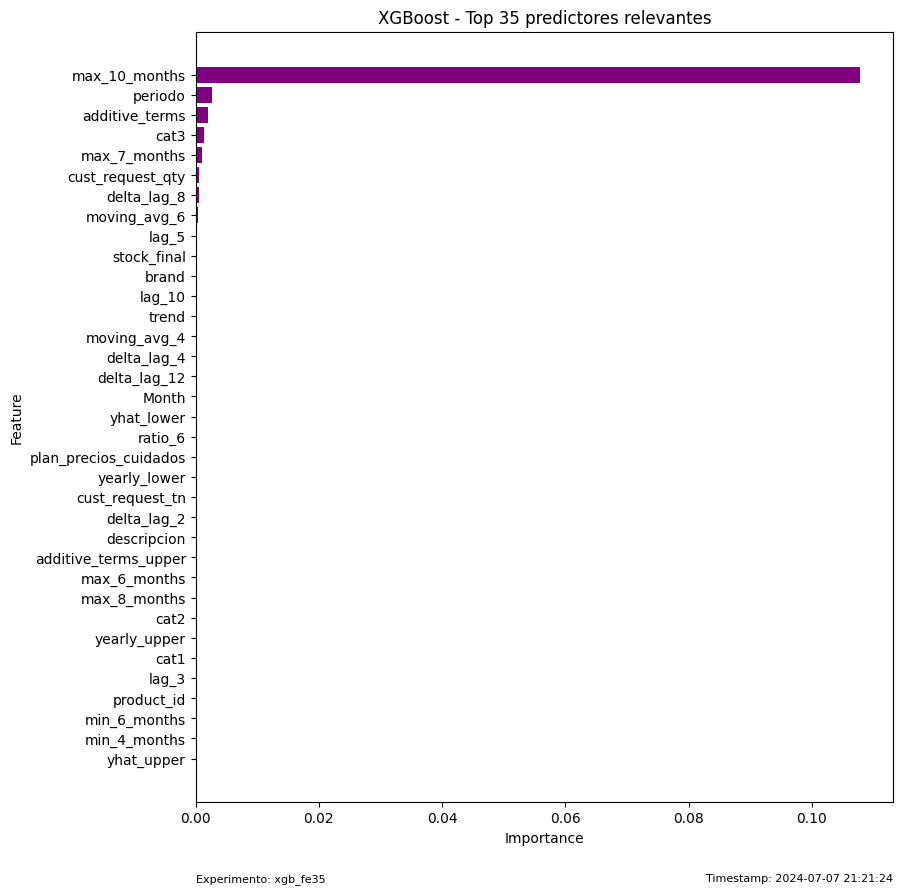

In [45]:
plot_top_features_importance(new_df, 35, EXPERIMENTO, PLOTS)

### Prediccion

In [102]:
df_test_202002 = test[['product_id', 'tn']]
df_test_202002['periodo'] = ['202001' if i % 2 == 0 else '202002' for i in range(len(test))]
df_test_202002['pred'] = predictions
df_test_202002['pred_seeds'] = predictions_seeds

df_test_202002 = df_test_202002[['product_id', 'periodo', 'tn', 'pred', 'pred_seeds']]

C:\Users\ferna\AppData\Local\Temp\ipykernel_7496\1809873736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_202002['periodo'] = ['202001' if i % 2 == 0 else '202002' for i in range(len(test))]
C:\Users\ferna\AppData\Local\Temp\ipykernel_7496\1809873736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_202002['pred'] = predictions
C:\Users\ferna\AppData\Local\Temp\ipykernel_7496\1809873736.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [103]:
df_test_202002

,product_id,periodo,tn,pred,pred_seeds
34,20001,202001,1397.37231,1.047446,0.921595
35,20001,202002,1504.68856,1.151849,0.989570
70,20002,202001,1423.57739,0.903189,0.389072
71,20002,202002,1087.30855,1.029784,1.134197
106,20003,202001,948.29393,0.678675,0.696629
...,...,...,...,...,...
22328,21266,202002,0.05121,10.393331,4.931036
22337,21267,202001,0.04052,4.748509,2.501384
22338,21267,202002,0.01569,11.385755,7.812829
22347,21276,202001,0.03341,1.201694,-0.064296


### Reconstruyo el ratio

In [104]:
last_tn_201912 = test[test['periodo'] == '2019-12-01'][['product_id', 'tn']].copy()
last_tn_201912.rename(columns={'tn': 'tn_201912'}, inplace=True)

In [105]:
last_tn_201912

,product_id,tn_201912
35,20001,1504.68856
71,20002,1087.30855
107,20003,892.50129
143,20004,637.90002
179,20005,593.24443
...,...,...
22308,21263,0.01270
22318,21265,0.05007
22328,21266,0.05121
22338,21267,0.01569


In [106]:
df_test_202002 = df_test_202002.merge(last_tn_201912, on='product_id')

In [107]:
df_test_202002

,product_id,periodo,tn,pred,pred_seeds,tn_201912
0,20001,202001,1397.37231,1.047446,0.921595,1504.68856
1,20001,202002,1504.68856,1.151849,0.989570,1504.68856
2,20002,202001,1423.57739,0.903189,0.389072,1087.30855
3,20002,202002,1087.30855,1.029784,1.134197,1087.30855
4,20003,202001,948.29393,0.678675,0.696629,892.50129
...,...,...,...,...,...,...
1555,21266,202002,0.05121,10.393331,4.931036,0.05121
1556,21267,202001,0.04052,4.748509,2.501384,0.01569
1557,21267,202002,0.01569,11.385755,7.812829,0.01569
1558,21276,202001,0.03341,1.201694,-0.064296,0.00892


In [108]:
df_test_202002['periodo'] = pd.to_datetime(df_test_202002['periodo'], format='%Y%m')

In [109]:
df_test_202002['tn_calculated'] = df_test_202002['tn'] * df_test_202002['pred']
df_test_202002['tn_calculated_seeds'] = df_test_202002['tn'] * df_test_202002['pred_seeds']

# Mostrar resultados
df_test_202002[['product_id', 'periodo', 'tn_calculated', 'tn_calculated_seeds']]

,product_id,periodo,tn_calculated,tn_calculated_seeds
0,20001,2020-01-01,1463.672387,1287.810886
1,20001,2020-02-01,1733.173702,1488.994781
2,20002,2020-01-01,1285.759614,553.874443
3,20002,2020-02-01,1119.692650,1233.222222
4,20003,2020-01-01,643.583323,660.608588
...,...,...,...,...
1555,21266,2020-02-01,0.532242,0.252518
1556,21267,2020-01-01,0.192410,0.101356
1557,21267,2020-02-01,0.178642,0.122583
1558,21276,2020-01-01,0.040149,-0.002148


### Armo el df final

In [110]:
df_final = df_test_202002[['product_id', 'periodo', 'tn_calculated', 'tn_calculated_seeds']].reset_index(drop=True)
df_final

,product_id,periodo,tn_calculated,tn_calculated_seeds
0,20001,2020-01-01,1463.672387,1287.810886
1,20001,2020-02-01,1733.173702,1488.994781
2,20002,2020-01-01,1285.759614,553.874443
3,20002,2020-02-01,1119.692650,1233.222222
4,20003,2020-01-01,643.583323,660.608588
...,...,...,...,...
1555,21266,2020-02-01,0.532242,0.252518
1556,21267,2020-01-01,0.192410,0.101356
1557,21267,2020-02-01,0.178642,0.122583
1558,21276,2020-01-01,0.040149,-0.002148


In [111]:
df_final = df_final.query("periodo == '2020-02-01'")

C:\Users\ferna\AppData\Local\Temp\ipykernel_7496\1177948855.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_final = df_final.query("periodo == '2020-02-01'")


In [112]:
df_final

,product_id,periodo,tn_calculated,tn_calculated_seeds
1,20001,2020-02-01,1733.173702,1488.994781
3,20002,2020-02-01,1119.692650,1233.222222
5,20003,2020-02-01,560.666273,671.300803
7,20004,2020-02-01,762.579523,774.469550
9,20005,2020-02-01,575.604643,564.610262
...,...,...,...,...
1551,21263,2020-02-01,0.049588,0.044986
1553,21265,2020-02-01,0.170069,0.215635
1555,21266,2020-02-01,0.532242,0.252518
1557,21267,2020-02-01,0.178642,0.122583


### Regular

In [113]:
total_target_sum = df_final['tn_calculated'].sum()

sum_first_12_rows = df_final.loc[0:11, 'tn_calculated'].sum()

division_result = sum_first_12_rows / total_target_sum

print("Total toneladas predicción':", total_target_sum)
print("Total toneladas Top 12:", sum_first_12_rows)
print("% toneladas Top 12:", division_result)

Total toneladas predicción': 30486.5323357663
Total toneladas Top 12: 5351.206676771833
% toneladas Top 12: 0.17552690538352522


### Semillas

In [114]:
total_target_sum = df_final['tn_calculated_seeds'].sum()

sum_first_12_rows = df_final.loc[0:11, 'tn_calculated_seeds'].sum()

division_result = sum_first_12_rows / total_target_sum

print("Total toneladas predicción':", total_target_sum)
print("Total toneladas Top 12:", sum_first_12_rows)
print("% toneladas Top 12:", division_result)

Total toneladas predicción': 30539.25118278062
Total toneladas Top 12: 5194.269871128863
% toneladas Top 12: 0.17008504367185082


### Kaggle

In [115]:
df_kaggle_reg = df_final[['product_id', 'tn_calculated']]
df_kaggle_reg.rename(columns={'tn_calculated':'tn'}, inplace=True)
df_kaggle_reg.to_csv(PREDS + f"/multinacional_{EXPERIMENTO}_reg.csv", float_format='%.6f', decimal='.', index=False)

df_kaggle_reg = df_final[['product_id', 'tn_calculated_seeds']]
df_kaggle_reg.rename(columns={'tn_calculated_seeds':'tn'}, inplace=True)
df_kaggle_reg.to_csv(PREDS + f"/multinacional_{EXPERIMENTO}_seeds.csv", float_format='%.6f', decimal='.', index=False)

C:\Users\ferna\AppData\Local\Temp\ipykernel_7496\337906818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kaggle_reg.rename(columns={'tn_calculated':'tn'}, inplace=True)
C:\Users\ferna\AppData\Local\Temp\ipykernel_7496\337906818.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kaggle_reg.rename(columns={'tn_calculated_seeds':'tn'}, inplace=True)


In [118]:
df_final[df_final['tn_calculated_seeds'] < 0]

,product_id,periodo,tn_calculated,tn_calculated_seeds
81,20044,2020-02-01,86.427297,-34.888190
247,20143,2020-02-01,75.033778,-47.315664
391,20239,2020-02-01,289.109525,-18.229475
465,20285,2020-02-01,19.642798,-3.943520
679,20421,2020-02-01,5.898414,-10.810921
863,20574,2020-02-01,3.074845,-0.610428
1097,20750,2020-02-01,3.832049,-180.250798
1253,20907,2020-02-01,-24.092079,-3.131664
1331,20982,2020-02-01,-0.863735,-1.368710
1347,20996,2020-02-01,-0.210366,-5.982077


### Manejo los ceros

In [121]:
def determine_tn(row):
    if row['tn_calculated'] < 0 and row['tn_calculated_seeds'] < 0:
        return 0
    elif row['tn_calculated'] >= 0:
        return row['tn_calculated']
    else:
        return row['tn_calculated_seeds']

def determine_tn_seeds(row):
    if row['tn_calculated'] < 0 and row['tn_calculated_seeds'] < 0:
        return 0
    elif row['tn_calculated_seeds'] >= 0:
        return row['tn_calculated_seeds']
    else:
        return row['tn_calculated']

df_final['tn'] = df_final.apply(determine_tn, axis=1)
df_final['tn_seeds'] = df_final.apply(determine_tn_seeds, axis=1)

# Crear dos DataFrames separados
df_tn = df_final[['product_id', 'tn']]
df_tn_seeds = df_final[['product_id', 'tn_seeds']]

C:\Users\ferna\AppData\Local\Temp\ipykernel_7496\1415591927.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['tn'] = df_final.apply(determine_tn, axis=1)
C:\Users\ferna\AppData\Local\Temp\ipykernel_7496\1415591927.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['tn_seeds'] = df_final.apply(determine_tn_seeds, axis=1)


In [122]:
df_tn

,product_id,tn
1,20001,1733.173702
3,20002,1119.692650
5,20003,560.666273
7,20004,762.579523
9,20005,575.604643
...,...,...
1551,21263,0.049588
1553,21265,0.170069
1555,21266,0.532242
1557,21267,0.178642


In [124]:
total_target_sum = df_tn['tn'].sum()

sum_first_12_rows = df_tn.loc[0:11, 'tn'].sum()

division_result = sum_first_12_rows / total_target_sum

print("Total toneladas predicción':", total_target_sum)
print("Total toneladas Top 12:", sum_first_12_rows)
print("% toneladas Top 12:", division_result)

Total toneladas predicción': 30848.313974761855
Total toneladas Top 12: 5351.206676771833
% toneladas Top 12: 0.17346836787092654


In [123]:
df_tn_seeds

,product_id,tn_seeds
1,20001,1488.994781
3,20002,1233.222222
5,20003,671.300803
7,20004,774.469550
9,20005,564.610262
...,...,...
1551,21263,0.044986
1553,21265,0.215635
1555,21266,0.252518
1557,21267,0.122583


In [126]:
total_target_sum = df_tn_seeds['tn_seeds'].sum()

sum_first_12_rows = df_tn_seeds.loc[0:11, 'tn_seeds'].sum()

division_result = sum_first_12_rows / total_target_sum

print("Total toneladas predicción':", total_target_sum)
print("Total toneladas Top 12:", sum_first_12_rows)
print("% toneladas Top 12:", division_result)

Total toneladas predicción': 31343.793236659207
Total toneladas Top 12: 5194.269871128863
% toneladas Top 12: 0.16571924884489497


In [127]:
df_kaggle_reg = df_tn[['product_id', 'tn']]
df_kaggle_reg.to_csv(PREDS + f"/multinacional_{EXPERIMENTO}_reg_fixed.csv", float_format='%.6f', decimal='.', index=False)

df_kaggle_seeds = df_final[['product_id', 'tn_seeds']]
df_kaggle_seeds.rename(columns={'tn_seeds':'tn'}, inplace=True)
df_kaggle_seeds.to_csv(PREDS + f"/multinacional_{EXPERIMENTO}_seeds_fixed.csv", float_format='%.6f', decimal='.', index=False)

C:\Users\ferna\AppData\Local\Temp\ipykernel_7496\1387992562.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kaggle_seeds.rename(columns={'tn_seeds':'tn'}, inplace=True)
